# Data Analysis and Classification Model on a Speed Dating Dataset | Eduardo Gonzalez | 10.6.23

## Business Problem

We created a new dating advice company, aimed at helping you find the love of your life.
By obtaining data from our client's feedback on different speed dates, we're looking to create a model to predict whether a date will be successful or not. By acquiring this data, we can then set up advising sessions where we got through what's important to get a good match in dating sites and find success in that area.

## Data Sources

For this problem, we're using the SpeedDating data source from Columbia University. Let's try to find what makes a couple match


# Import packages and data

In [1]:
#Import necessary packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import ParameterGrid
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, roc_curve, auc
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix
from sklearn.metrics import RocCurveDisplay
from imblearn.over_sampling import SMOTE
from sklearn.tree import DecisionTreeClassifier, plot_tree
%matplotlib inline
from sklearn.model_selection import train_test_split, cross_val_score
from scipy.io import arff

# Importing the Data
 This database comes in an .arff format, we download the right package for it and open the file, decoding it in order to look at it properly


In [2]:
data, meta = arff.loadarff('data/speeddating.arff')

df = pd.DataFrame(data)

for column in df.columns:
    if df[column].dtype == 'object':
        df[column] = df[column].str.decode('utf-8')

In [3]:
df.shape

(8378, 123)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8378 entries, 0 to 8377
Columns: 123 entries, has_null to match
dtypes: float64(59), object(64)
memory usage: 7.9+ MB


## Exploring the null values

In [5]:
df.isna().sum().sum()

18173

In [6]:
# Checking for null values
df.isna().sum().sort_values(ascending=False)

expected_num_interested_in_me    6578
expected_num_matches             1173
shared_interests_o               1076
shared_interests_partner         1067
ambitous_o                        722
                                 ... 
d_funny_important                   0
d_intellicence_important            0
d_sincere_important                 0
d_attractive_important              0
match                               0
Length: 123, dtype: int64

In [7]:
#Dropping unnecessary columns and with more than 10% of null data
df.drop(columns=['expected_num_interested_in_me','expected_num_matches','shared_interests_o','shared_interests_partner','has_null','ambitous_o','ambition_partner'],inplace=True)

## Null values decision

In this specific dataset, every data point is an individual preference of the person, so we can't just fill the null values with any type of aggregation, since that would not only alter our distribution, but it'll also change how the data behaves completely since the preferences play an important role in whether two people will match or not.

Since this database is large enough, we decide to drop the row that has any missing values, in to be able to work with real and trustworthy data.

In [8]:
#Dropping null values
df.dropna(how='any', inplace=True)

## Evaluating the balance of our target variable

In [9]:
df.match.value_counts(normalize=True)

match
0    0.825682
1    0.174318
Name: proportion, dtype: float64

As we can see, we're looking at a data that is really unbalanced, since 82% of our target variable is 0, against just a 17% that's 1.

## Exploring the columns

This dataset in particular counts 116 columns, we need to somehow check what's the values on each one of them to be able to work with them correctly

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7079 entries, 0 to 8377
Columns: 116 entries, wave to match
dtypes: float64(53), object(63)
memory usage: 6.3+ MB


## Adjusting Object Columns

We're going to now explore and evaluate the object columns and check if there's any preprocessing that can be done before splitting train and test data.

In [11]:
df.select_dtypes(include=['float64']).info()

<class 'pandas.core.frame.DataFrame'>
Index: 7079 entries, 0 to 8377
Data columns (total 53 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   wave                           7079 non-null   float64
 1   age                            7079 non-null   float64
 2   age_o                          7079 non-null   float64
 3   d_age                          7079 non-null   float64
 4   importance_same_race           7079 non-null   float64
 5   importance_same_religion       7079 non-null   float64
 6   pref_o_attractive              7079 non-null   float64
 7   pref_o_sincere                 7079 non-null   float64
 8   pref_o_intelligence            7079 non-null   float64
 9   pref_o_funny                   7079 non-null   float64
 10  pref_o_ambitious               7079 non-null   float64
 11  pref_o_shared_interests        7079 non-null   float64
 12  attractive_o                   7079 non-null   float6

By exploring the columns, we notice that most of them are in some sort or ranking of preference, by exploring them individually we reallize that most of the columns that have that type move on the range from 0 to 10 or from 0 to 100. We can change those strings to 0,1 and 2, without creating any data leakage.

In [12]:
# We create empty list to be able to categorize the columns for further preprocessing.
categorical_columns = []
numerical_columns = []
to_drop_columns = []
binary_columns = []

In [13]:
#Move all the names of the columns to a list
float_column_list = df.select_dtypes(include=['float64']).columns.tolist()
object_column_list = df.select_dtypes(include=['object']).columns.tolist()
#We create two list, one that will include the columns which values are within 1 and 10. And another for the same but with the range 1 to 100.
# Also we include a list of the columns that won't include those two ranges.
range_1_10 = []
range_1_100 = []
columns_to_analyze = []
# Create also two list of the possible strings that we'll encounter in either of the columns to classify.

string_ranges_1_100 = ['[0-15]','[16-20]','[21-100]']
string_ranges_1_10 = ['[6-8]','[9-10]','[0-5]']

#Evaluating if a value of the column falls into either category and adding them to the corresponding list.

for column in object_column_list:
    if df[column][0] in string_ranges_1_10:
        range_1_10.append(column)
    elif df[column][0] in string_ranges_1_100:
        range_1_100.append(column)
    else:
        columns_to_analyze.append(column)

# We also create a dictionary with the ranges, and the integer value we'd use to replace it. We'd only use 0,1,2 for this.

dict_1_10 = {'[0-5]':0,'[6-8]':1,'[9-10]':2}
dict_1_100 = {'[0-15]':0,'[16-20]':1,'[21-100]':2}

#Replacing the values on the corresponding columns. Also adding the name into the numerical columns list to have them classified for further processing.

for i in range_1_10:
    df[i] = df[i].replace(dict_1_10)
    numerical_columns.append(i)

for i in range_1_100:
    df[i] = df[i].replace(dict_1_100)
    numerical_columns.append(i)

In [14]:
#Checking the columns that didn't had part of that range and have to be analyzed based on something else.
columns_to_analyze

['gender',
 'd_d_age',
 'race',
 'race_o',
 'samerace',
 'd_importance_same_race',
 'd_importance_same_religion',
 'field',
 'd_interests_correlate',
 'd_expected_happy_with_sd_people',
 'd_expected_num_interested_in_me',
 'd_expected_num_matches',
 'd_guess_prob_liked',
 'decision',
 'decision_o',
 'match']

### Individual column analysis

In [15]:
df['gender'].value_counts()

gender
female    3542
male      3537
Name: count, dtype: int64

In [16]:
#Add to our categorical columns, eliminate from the 'columns_to_analyze' list.
categorical_columns.append('gender')
columns_to_analyze.remove('gender')

In [17]:
df.d_d_age.value_counts()

d_d_age
[2-3]     2093
[4-6]     1998
[0-1]     1937
[7-37]    1051
Name: count, dtype: int64

This column is too similar to the 'd_age' one, one shows the difference on age, and the other just shows a range of difference.

Being this the case, we'll drop d_d_age

In [18]:
# Adding to the to_drop_columns and remove from the columns_to_analyze
to_drop_columns.append('d_d_age')
columns_to_analyze.remove('d_d_age')

In [19]:
df['race'].value_counts()

race
European/Caucasian-American              3992
Asian/Pacific Islander/Asian-American    1721
Latino/Hispanic American                  552
Other                                     477
Black/African American                    337
Name: count, dtype: int64

For this column, we just need to clean the name values to make them shorter.

In [20]:
# Creating a dictionary to set shorter names for the different categories
race_dict = {'European/Caucasian-American': 'Caucasian',
             'Asian/Pacific Islander/Asian-American':'Asian',
             'Latino/Hispanic American':'Latino',
             'Black/African American':'Black'
            }

# Replacing the values for the shorter name, and adding the column to the categorical_column list
df['race'] = df['race'].replace(race_dict)
categorical_columns.append('race')
columns_to_analyze.remove('race')

In [21]:
df['race_o'].value_counts()

race_o
European/Caucasian-American              3965
Asian/Pacific Islander/Asian-American    1735
Latino/Hispanic American                  567
Other                                     467
Black/African American                    345
Name: count, dtype: int64

In [22]:
# Applying same principle to the race_o column
df['race_o'] = df['race_o'].replace(race_dict)
categorical_columns.append('race_o')
columns_to_analyze.remove('race_o')

## Same Race

This column is directly related to the other two that we just evaluate. there's a correlation there, since if both column 'race' and column 'race_o' have the same value, we can predict the value of the 'samerace' column. We'd add to to the to_drop list.

In [23]:
to_drop_columns.append('samerace')
columns_to_analyze.remove('samerace')

In [24]:
df['d_importance_same_race'].value_counts()

d_importance_same_race
[2-5]     2654
[0-1]     2379
[6-10]    2046
Name: count, dtype: int64

We notice here, and below we'll confirm, that many of our columns have that string notation some different ranges, we're going to transform them in ordinal values to make it usable for our models.

We'll create a function to transform this one an any further column with the same style, also, it'll automatically add it to our numerical_columns list and remove it from the columns_to_analyze

In [25]:
#Creating the transforming dictionary
def range_trans(column, dict):
    df[column] = df[column].replace(dict)
    numerical_columns.append(column)
    columns_to_analyze.remove(column)

In [26]:
df['d_importance_same_race'].value_counts()

d_importance_same_race
[2-5]     2654
[0-1]     2379
[6-10]    2046
Name: count, dtype: int64

In [27]:
# Transforming the ranges into integers and adding it to the numerical_colums list
importance_dict = {'[2-5]':1,'[0-1]':0,'[6-10]':2}
range_trans('d_importance_same_race',importance_dict)

In [28]:
df['d_importance_same_religion'].value_counts()

d_importance_same_religion
[0-1]     2585
[2-5]     2555
[6-10]    1939
Name: count, dtype: int64

In [29]:
# Transforming the ranges into integers and adding it to the numerical_colums list
range_trans('d_importance_same_religion',importance_dict)

In [30]:
df['d_interests_correlate'].value_counts()

d_interests_correlate
[0-0.33]    2626
[0.33-1]    2559
[-1-0]      1894
Name: count, dtype: int64

In [31]:
# Creating new dictionary adapted to this column's ranges and transforming
corr_dict = {'[-1-0]':0,'[0-0.33]':1,'[0.33-1]':2}
range_trans('d_interests_correlate',corr_dict)

In [32]:
df['d_expected_happy_with_sd_people'].value_counts()

d_expected_happy_with_sd_people
[5-6]     3500
[7-10]    1948
[0-4]     1631
Name: count, dtype: int64

In [33]:
# Creating new dictionary adapted to this column's ranges and transforming
expectation_dict = {'[0-4]':0,'[5-6]':1,'[7-10]':2}
range_trans('d_expected_happy_with_sd_people',expectation_dict)

In [34]:
df['d_expected_num_interested_in_me'].value_counts()

d_expected_num_interested_in_me
[0-3]      6208
[4-9]       542
[10-20]     329
Name: count, dtype: int64

In [35]:
# Creating new dictionary adapted to this column's ranges and transforming
expectation_dict2 = {'[0-3]':0,'[4-9]':1,'[10-20]':2}
range_trans('d_expected_num_interested_in_me',expectation_dict2)

In [36]:
df['d_expected_num_matches'].value_counts()

d_expected_num_matches
[0-2]     3752
[3-5]     2473
[5-18]     854
Name: count, dtype: int64

In [37]:
# Creating new dictionary adapted to this column's ranges and transforming
expectation_dict3 = {'[0-2]':0,'[3-5]':1,'[5-18]':2}
range_trans('d_expected_num_matches',expectation_dict3)

In [38]:
df['d_guess_prob_liked'].value_counts()

d_guess_prob_liked
[5-6]     2840
[0-4]     2256
[7-10]    1983
Name: count, dtype: int64

In [39]:
range_trans('d_guess_prob_liked',expectation_dict)

For the 'decision' and 'decision_o' columns, there're going to be making noise on my model, since just by loooking at the two of them I can tell the target variable, therefore I'll proceed to add them to the to_drop_columns and remove them from the columns to analyze.

In [40]:
to_drop_columns.append('decision')
to_drop_columns.append('decision_o')
columns_to_analyze.remove('decision')
columns_to_analyze.remove('decision_o')

In [41]:
#Removing all the unnecessary columns
df = df.drop(columns=to_drop_columns)

Now, we're going to observe the values of our column list so evaluate if everything is in order.

In [42]:
for i in float_column_list:
    print(df[i].value_counts())

wave
11.0    796
21.0    774
9.0     697
4.0     574
15.0    568
14.0    556
2.0     486
7.0     470
19.0    396
12.0    348
17.0    261
1.0     192
8.0     167
3.0     154
10.0    143
5.0     128
13.0    124
16.0     84
20.0     76
18.0     55
6.0      30
Name: count, dtype: int64
age
27.0    892
23.0    806
24.0    770
25.0    741
26.0    703
28.0    659
22.0    565
30.0    477
29.0    466
21.0    249
32.0    182
33.0    143
34.0    121
31.0    119
35.0     55
20.0     36
36.0     35
42.0     18
38.0     16
19.0      9
18.0      8
55.0      5
39.0      2
37.0      2
Name: count, dtype: int64
age_o
27.0    885
23.0    795
24.0    757
25.0    735
26.0    731
28.0    653
22.0    556
30.0    500
29.0    479
21.0    250
32.0    178
33.0    141
34.0    123
31.0    114
35.0     54
36.0     35
20.0     34
42.0     18
38.0     14
19.0     12
18.0      7
55.0      4
37.0      2
39.0      2
Name: count, dtype: int64
d_age
1.0     1331
2.0     1111
3.0      982
4.0      815
5.0      675
0.0     

By looking at the value counts of the columns with type float, I can see that everything is in order except for one.

The 'met' column is supposed to have a binary value based on whether they met or not. In this case there are 5 rows that are different from that criteria, we'd drop them.

In [43]:
#Keeping just the values of 'met' between 0 and 1.
df = df[df['met'].isin([0, 1])]
binary_columns.append('met')
float_column_list.remove('met')

In [44]:
df.head()

,wave,gender,age,age_o,d_age,race,race_o,importance_same_race,importance_same_religion,d_importance_same_race,...,expected_happy_with_sd_people,d_expected_happy_with_sd_people,d_expected_num_interested_in_me,d_expected_num_matches,like,guess_prob_liked,d_like,d_guess_prob_liked,met,match
0,1.0,female,21.0,27.0,6.0,Asian,Caucasian,2.0,4.0,1,...,3.0,0,0,1,7.0,6.0,1,1,0.0,0
1,1.0,female,21.0,22.0,1.0,Asian,Caucasian,2.0,4.0,1,...,3.0,0,0,1,7.0,5.0,1,1,1.0,0
3,1.0,female,21.0,23.0,2.0,Asian,Caucasian,2.0,4.0,1,...,3.0,0,0,1,7.0,6.0,1,1,0.0,1
4,1.0,female,21.0,24.0,3.0,Asian,Latino,2.0,4.0,1,...,3.0,0,0,1,6.0,6.0,1,1,0.0,1
5,1.0,female,21.0,25.0,4.0,Asian,Caucasian,2.0,4.0,1,...,3.0,0,0,1,6.0,5.0,1,1,0.0,0


In [45]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7074 entries, 0 to 8377
Columns: 112 entries, wave to match
dtypes: float64(53), int64(54), object(5)
memory usage: 6.1+ MB


In [46]:
df['field'].nunique()

256

### Field Column

The field column has 256 unique values, to be able to categorize them properly, since some of them are variations with spelling differences and others are slightly different fields (such as Finance and money, for example), we created two field filters dictionaries to be able to bring them down to 21 broader terms that can explain those fields and allow us to further in the process to one hot encode them. Without this method, the column would've been completely useless.

In [47]:
#Creating filter dictionaries to clean the column

field_filter = {
    'Law': 'Law and Legal Studies','law': 'Legal Studies','Economics': 'Economics','Masters in Public Administration': 'Public Administration',
    'Masters of Social Work&Education': 'Social Work/Education','Finance': 'Finance','Business': 'Business','political science': 'Political Science',
    'money': 'Finance','Operations Research': 'Operations Research','TC [Health Ed]': 'Health Education','Psychology': 'Psychology','social work': 'Social Work',
    'Social Work': 'Social Work','Speech Language Pathology': 'Speech Pathology','Educational Psychology': 'Psychology','Applied Maths/Econs': 'Mathematics',
    'Mathematics': 'Mathematics','Statistics': 'Statistics','Organizational Psychology': 'Psychology','Mechanical Engineering': 'Engineering',
    'Finanace': 'Finance','Finance&Economics': 'Finance','Undergrad - GS': 'Education','Mathematical Finance': 'Finance','Medicine': 'Medicine',
    'MBA': 'Business Administration','LAW': 'Legal Studies','psychology': 'Psychology','German Literature': 'Literature','Business & International Affairs': 'Business Administration',
    'MFA Creative Writing': 'Creative Writing','Engineering': 'Engineering','Electrical Engineering': 'Engineering','Classics': 'Classics',
    'Operations Research [SEAS]': 'Operations Research','chemistry': 'Chemistry','Journalism': 'Journalism','Elementary/Childhood Education [MA]': 'Education',
    'microbiology': 'Microbiology','Masters of Social Work': 'Social Work','Communications': 'Communications','Marketing': 'Marketing','Chemistry': 'Chemistry',
    'International Educational Development': 'Education','Education Administration': 'Education','Business [MBA]': 'Business Administration',
    'Computer Science': 'Computer Science','Climate-Earth and Environ. Science': 'Environmental Science','financial math': 'Finance','Business- MBA': 'Business Administration',
    'Religion': 'Religion','Film': 'Film','Sociology': 'Sociology','Economics; English': 'Economics','Economics; Sociology': 'Economics',
    'Polish': 'Languages','English': 'Languages','psychology and english': 'Psychology','Biomedical Engineering': 'Engineering',
    'Economics and Political Science': 'Economics','Art History/medicine': 'Art History','philosophy': 'Philosophy','electrical engineering': 'Engineering',
    'marine geophysics': 'Geophysics','theory': 'Theory','engineering': 'Engineering','Nutrition/Genetics': 'Biology','Neuroscience': 'Neuroscience',
    'Comparative Literature': 'Literature','International Relations': 'International Relations','History of Religion': 'Religion',
    'international affairs - economic development': 'International Affairs','Political Science': 'Political Science',
    'Modern Chinese Literature': 'Literature','business': 'Business','Business; marketing': 'Business Administration','physics [astrophysics]': 'Physics',
    'Physics': 'Physics','Business/ Finance/ Real Estate': 'Business Administration','Biochemistry': 'Biochemistry','Art Education': 'Education',
    'Philosophy': 'Philosophy','American Studies [Masters]': 'American Studies','biology': 'Biology','Cell Biology': 'Biology',
    'Microbiology': 'Microbiology','math': 'Mathematics','International Affairs/Finance': 'International Affairs',
    'International Affairs': 'International Affairs','international affairs/international finance': 'International Affairs','Health policy': 'Health Policy',
    'English and Comp Lit': 'Languages','international finance and business': 'Finance','Sociomedical Sciences- School of Public Health': 'Public Health',
    'Epidemiology': 'Epidemiology','Social work': 'Social Work','International Business': 'Business Administration','Medical Informatics': 'Health Informatics',
    'International Finance; Economic Policy': 'Finance','Law and Social Work': 'Law and Legal Studies','International Development': 'International Affairs',
    'Business/Law': 'Business Administration','Clinical Psychology': 'Psychology','Religion; GSAS': 'Religion','International Affairs and Public Health': 'International Affairs',
    'International affairs': 'International Affairs','History': 'History','Business and International Affairs [MBA/MIA Dual Degree]': 'Business Administration',
    'QMSS': 'Quantitative Methods','climate change': 'Environmental Science','Public Administration': 'Public Administration','MA Biotechnology': 'Biotechnology',
    'International Affairs/Business': 'International Affairs','Ecology': 'Environmental Science','Master in Public Administration': 'Public Administration',
    'Computational Biochemsistry': 'Biochemistry','Neurobiology': 'Neuroscience','Mathematics; PhD': 'Mathematics','History [GSAS - PhD]': 'History',
    'biomedicine': 'Biochemistry','Master of International Affairs': 'International Affairs','Sociology and Education': 'Sociology',
    'elementary education': 'Education','Biology': 'Biology','American Studies': 'American Studies','Arts Administration': 'Arts Administration',
    'Conservation biology': 'Biology','sociology': 'Sociology','Japanese Literature': 'Literature','biotechnology': 'Biotechnology',
    'Earth and Environmental Science': 'Environmental Science','Philosophy [Ph.D.]': 'Philosophy','Philosophy and Physics': 'Philosophy',
    'nutrition': 'Nutrition','MA Science Education': 'Education','Genetics': 'Genetics','Law and English Literature [J.D./Ph.D.]': 'Legal Studies',
    'french': 'Languages','Nutritiron': 'Nutrition','GS Postbacc PreMed': 'Pre-Med','Art History': 'Art History','Molecular Biology': 'Molecular Biology',
    'Genetics & Development': 'Genetics','medical informatics': 'Health Informatics','Electrical Engg.': 'Engineering',
    'Business School': 'Business Administration','International Politics': 'International Affairs','MBA / Master of International Affairs [SIPA]': 'Business Administration',
    'genetics': 'Genetics','medicine and biochemistry': 'Medicine','Social Studies Education': 'Education','MA Teaching Social Studies': 'Education',
    'Education Policy': 'Education','Education- Literacy Specialist': 'Education','Anthropology/Education': 'Anthropology',
    'bilingual education': 'Education','speech pathology': 'Speech Pathology','Education': 'Education','Speech Pathology': 'Speech Pathology',
    'math education': 'Education','TESOL': 'Education','Elementary Education': 'Education','Cognitive Studies in Education': 'Education',
    'education': 'Education','Finance/Economics': 'Finance','Museum Anthropology': 'Anthropology','Environmental Engineering': 'Environmental Engineering',
    'Business Administration': 'Business Administration','Curriculum and Teaching/Giftedness': 'Education','Instructional Tech & Media': 'Education',
    'School Psychology': 'Psychology','Instructional Media and Technology': 'Education','SIPA / MIA': 'International Affairs',
    'English Education': 'Education','art education': 'Education','MA in Quantitative Methods': 'Quantitative Methods',
    'Early Childhood Education': 'Education','anthropology': 'Anthropology','Architecture': 'Architecture','Urban Planning': 'Urban Planning',
    'Ed.D. in higher education policy at TC': 'Education','International Security Policy - SIPA': 'International Affairs',
    'Nutrition': 'Nutrition','EDUCATION': 'Education','Applied Physiology & Nutrition': 'Nutrition','music education': 'Music Education',
    'Music Education': 'Music Education','Counseling Psychology': 'Psychology','Communications in Education': 'Education',
    'Intellectual Property Law': 'Law','MBA Finance': 'Business Administration','Intrernational Affairs': 'International Affairs',
    'BUSINESS CONSULTING': 'Business Administration','business school': 'Business Administration',
    'Business; Media': 'Business Administration','MFA -Film': 'Film','Higher Ed. - M.A.': 'Education','Neuroscience and Education': 'Neuroscience',
    'Creative Writing': 'Creative Writing','Creative Writing - Nonfiction': 'Creative Writing','Writing: Literary Nonfiction': 'Creative Writing',
    'Creative Writing [Nonfiction]': 'Creative Writing','NonFiction Writing': 'Creative Writing','Theatre Management & Producing': 'Theatre',
    'Financial Engineering': 'Finance','biomedical engineering': 'Biomedical Engineering','Fundraising Management': 'Management',
    'Business [Finance & Marketing]': 'Business Administration','Elementary Education - Preservice': 'Education','Education Leadership - Public School Administration': 'Education',
    'MFA Writing': 'Creative Writing','Bilingual Education': 'Education','International Affairs - Economic Policy': 'International Affairs',
    'SIPA - Energy': 'Energy','Public Policy': 'Public Policy','Law/Business': 'Legal Studies','MFA  Poetry': 'Creative Writing',
    'SOA -- writing': 'Creative Writing','biomedical informatics': 'Health Informatics','physics': 'Physics','working': 'Other',
    'Consulting': 'Consulting','Human Rights: Middle East': 'Human Rights','Human Rights': 'Human Rights','medicine': 'Medicine',
    'Biotechnology': 'Biotechnology','SIPA-International Affairs': 'International Affairs','teaching of English': 'Education','GSAS': 'Other',
    'African-American Studies/History': 'African-American Studies','Neurosciences/Stem cells': 'Neuroscience','film': 'Film','journalism': 'Journalism',
    'Theater': 'Theatre','Biology PhD': 'Biology','biochemistry/genetics': 'Biochemistry','epidemiology': 'Epidemiology','Stats': 'Statistics',
    'math of finance': 'Mathematics','MFA Acting Program': 'Acting','Nonfiction writing': 'Creative Writing','Biochemistry & Molecular Biophysics': 'Biochemistry',
    'Acting': 'Acting','Social Work/SIPA': 'Social Work','Public Health': 'Public Health','ELECTRICAL ENGINEERING': 'Engineering',
    'Math': 'Mathematics','Biomedical engineering': 'Biomedical Engineering','Industrial Engineering': 'Industrial Engineering',
    'Industrial Engineering/Operations Research': 'Operations Research','Masters of Industrial Engineering': 'Industrial Engineering',
    'Biomedical Informatics': 'Health Informatics','MBA - Private Equity / Real Estate': 'Business Administration',
    'General management/finance': 'Business Administration','Climate Dynamics': 'Environmental Science',
}

field_filter2 = {
    'Legal Studies': 'Law and Legal Studies','Economics': 'Social Sciences','Public Administration': 'Public Administration',
    'Social Work/Education': 'Social Sciences','Finance': 'Business and Finance','Business': 'Business and Finance',
    'Political Science': 'Social Sciences','Operations Research': 'Mathematics and Statistics','Health Education': 'Health Sciences and Medicine',
    'Psychology': 'Psychology','Social Work': 'Social Sciences','Speech Pathology': 'Health Sciences and Medicine',
    'Mathematics': 'Mathematics and Statistics','Statistics': 'Mathematics and Statistics','Engineering': 'Engineering',
    'Education': 'Education','Medicine': 'Health Sciences and Medicine','Business Administration': 'Business and Finance',
    'Literature': 'Humanities','Creative Writing': 'Humanities','Classics': 'Humanities','Chemistry': 'Physical Sciences',
    'Journalism': 'Communications','Microbiology': 'Biology','Marketing': 'Business and Finance','Environmental Science': 'Environmental Sciences',
    'Religion': 'Humanities','Film': 'Arts and Media','Sociology': 'Social Sciences','Languages': 'Languages and Linguistics','Art History': 'Humanities',
    'Philosophy': 'Humanities','Geophysics': 'Physical Sciences','Theory': 'Social Sciences','Biology': 'Biology','Neuroscience': 'Health Sciences and Medicine',
    'International Relations': 'Social Sciences','International Affairs': 'Social Sciences','Physics': 'Physical Sciences','Biochemistry': 'Biology',
    'American Studies': 'Social Sciences','Health Policy': 'Health Sciences and Medicine','Public Health': 'Health Sciences and Medicine','Epidemiology': 'Health Sciences and Medicine',
    'Health Informatics': 'Health Sciences and Medicine','History': 'Humanities','Quantitative Methods': 'Mathematics and Statistics','Biotechnology': 'Biology',
    'Arts Administration': 'Arts and Media','Nutrition': 'Health Sciences and Medicine','Genetics': 'Biology','Pre-Med': 'Health Sciences and Medicine',
    'Molecular Biology': 'Biology','Anthropology': 'Social Sciences','Environmental Engineering': 'Engineering','Architecture': 'Other',
    'Urban Planning': 'Other','Music Education': 'Arts and Media','Law': 'Law and Legal Studies','Theatre': 'Arts and Media',
    'Biomedical Engineering': 'Engineering','Management': 'Business and Finance','Energy': 'Environmental Sciences','Public Policy': 'Social Sciences',
    'Other': 'Other','Consulting': 'Business and Finance','Human Rights': 'Social Sciences','African-American Studies': 'Social Sciences',
    'Acting': 'Arts and Media','Industrial Engineering': 'Engineering',
}

In [48]:
#Replacing the values and adding it to the categorical_colums list

df['field'] = df['field'].replace(field_filter)
df['field'] = df['field'].replace(field_filter2)
categorical_columns.append('field')

## EDA

Now let's explore our data before start the modeling.

In [49]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7074 entries, 0 to 8377
Columns: 112 entries, wave to match
dtypes: float64(53), int64(54), object(5)
memory usage: 6.1+ MB


In [50]:
df.describe()

,wave,age,age_o,d_age,importance_same_race,importance_same_religion,d_importance_same_race,d_importance_same_religion,pref_o_attractive,pref_o_sincere,...,d_interests_correlate,expected_happy_with_sd_people,d_expected_happy_with_sd_people,d_expected_num_interested_in_me,d_expected_num_matches,like,guess_prob_liked,d_like,d_guess_prob_liked,met
count,7074.000000,7074.000000,7074.000000,7074.000000,7074.000000,7074.000000,7074.000000,7074.000000,7074.000000,7074.000000,...,7074.000000,7074.000000,7074.000000,7074.000000,7074.000000,7074.000000,7074.000000,7074.000000,7074.000000,7074.000000
mean,11.300961,26.304354,26.315522,3.620441,3.781170,3.656064,0.952643,0.908256,22.233627,17.445638,...,1.093582,5.516257,1.044247,0.169353,0.590755,6.155669,5.253251,0.749647,0.960843,0.045943
std,5.958576,3.509872,3.484160,2.985518,2.832005,2.817213,0.789362,0.794212,12.376186,6.931630,...,0.787651,1.729667,0.709567,0.483155,0.695183,1.813615,2.110832,0.579301,0.772802,0.209376
min,1.000000,18.000000,18.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,7.000000,24.000000,24.000000,1.000000,1.000000,1.000000,0.000000,0.000000,15.000000,15.000000,...,0.000000,5.000000,1.000000,0.000000,0.000000,5.000000,4.000000,0.000000,0.000000,0.000000
50%,11.000000,26.000000,26.000000,3.000000,3.000000,3.000000,1.000000,1.000000,20.000000,18.370000,...,1.000000,6.000000,1.000000,0.000000,0.000000,6.000000,5.000000,1.000000,1.000000,0.000000
75%,15.000000,28.000000,28.000000,5.000000,6.000000,6.000000,2.000000,2.000000,25.000000,20.000000,...,2.000000,7.000000,2.000000,0.000000,1.000000,7.000000,7.000000,1.000000,2.000000,0.000000
max,21.000000,55.000000,55.000000,32.000000,10.000000,10.000000,2.000000,2.000000,100.000000,47.000000,...,2.000000,10.000000,2.000000,2.000000,2.000000,10.000000,10.000000,2.000000,2.000000,1.000000


Let's look at the age distribution

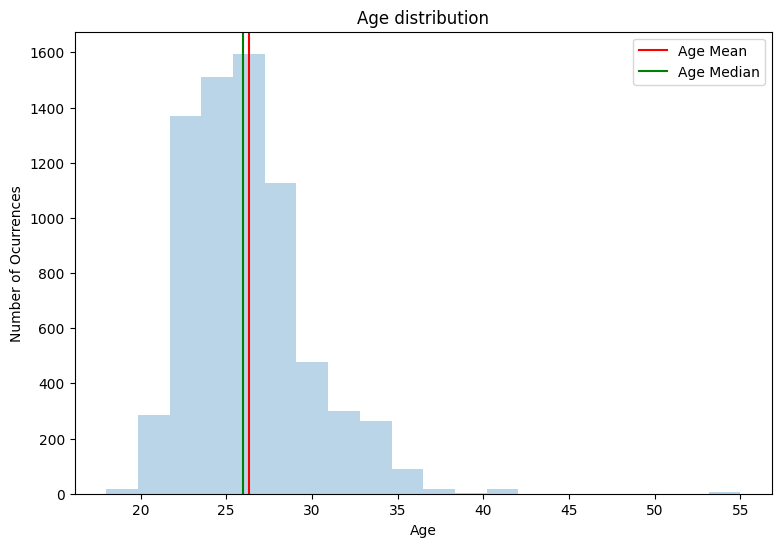

In [51]:
fig, ax = plt.subplots(figsize=(9,6))
ax.hist(df['age'], alpha=0.3, bins=20)
ax.set_title('Age distribution')
ax.set_ylabel('Number of Ocurrences')
ax.axvline(df['age'].mean(),color='red',label='Age Mean')
ax.axvline(df['age'].median(),color='green',label='Age Median')
ax.set_xlabel('Age')
ax.legend();

As we can see here the distribution is slightly skewed with some outliers that don't affect too much the difference between the median and the mean.

### Race & Gender

Let's see the comparison of % of people per Race and by Gender

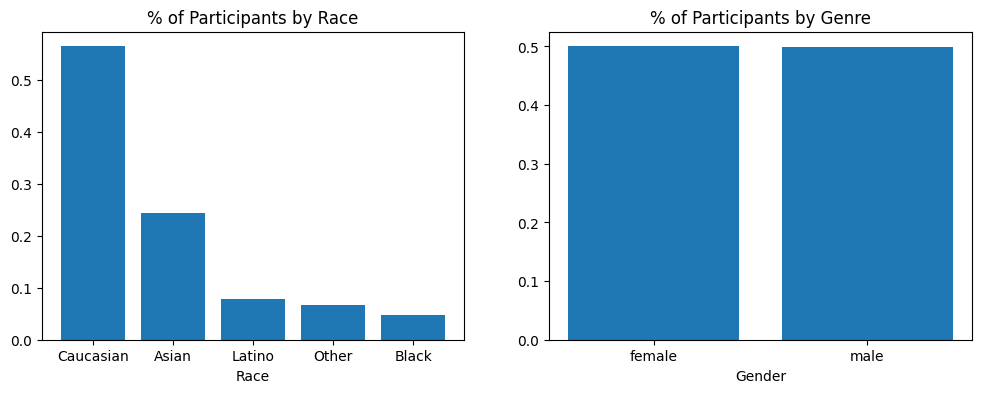

In [52]:
fig, ax = plt.subplots(ncols=2,figsize=(12,4))
x_0 = df['race'].value_counts().index
y_0 = df['race'].value_counts(normalize=True)
ax[0].set_title("% of Participants by Race")
#ax.set_ylabel("%")
ax[0].set_xlabel("Race")
ax[0].bar(x_0, height=y_0);
x_1 = df['gender'].value_counts().index
y_1 = df['gender'].value_counts(normalize=True)
ax[1].bar(x_1, height=y_1)
ax[1].set_title("% of Participants by Genre")
ax[1].set_xlabel("Gender");

As we can see above, the Caucasian population has a larger precense in our dataset, and there also seems to be almost an equal amount of male and females.

## Splitting the Dataset

We did some renaming on the values of the columns, but most of our pre-processing can't be done without risking some data leakage, we're going to do the splitting now, keeping a 25% of the data as Test.

In [53]:
# Splitting our data set
X = df.drop('match',axis=1)
y = df['match'].astype(int)
X_train, X_test, y_train,y_test = train_test_split(X, y, test_size=0.25, random_state=420)

In [54]:
#Extending our numerical_column list to include them all and have it ready to analyze.
numerical_columns.extend(float_column_list)

## Preprocessing

We'll do the steps in the Train and Test data in parallel, so we can keep an order on it.

In [55]:
#Getting a subset of just the numerical columns
X_train_numerical = X_train[numerical_columns].copy()
X_test_numerical = X_test[numerical_columns].copy()

#Instantiating a scaler, fitting on the training data and transforming them, setting them back as a DataFrame
scaler = StandardScaler()
X_train_num_scaled = scaler.fit_transform(X_train_numerical)
X_test_num_scaled = scaler.transform(X_test_numerical)
X_train_num_scaled = pd.DataFrame(X_train_num_scaled, columns=X_train_numerical.columns)
X_test_num_scaled = pd.DataFrame(X_test_num_scaled, columns=X_train_numerical.columns)

#Creating a subset of categorical and binary columns for both Train and Test data
X_train_categorical = X_train[categorical_columns].copy()
X_test_categorical = X_test[categorical_columns].copy()
X_train_bin = X_train[binary_columns].copy()
X_test_bin = X_test[binary_columns].copy()

#Instantiating One Hot Encoder, fitting and transforming on the train data, transforming the test data. Make sure to drop a column.
ohe = OneHotEncoder(sparse_output=False,drop='first',handle_unknown='ignore')
X_train_cat_encoded = ohe.fit_transform(X_train_categorical)
X_test_cat_encoded = ohe.transform(X_test_categorical)
X_train_cat_encoded = pd.DataFrame(X_train_cat_encoded, columns=ohe.get_feature_names_out())
X_test_cat_encoded = pd.DataFrame(X_test_cat_encoded, columns=ohe.get_feature_names_out())

#Resetting indexes for the train and test data to make possible the concatenation.
X_train_num_scaled.reset_index(drop=True, inplace=True)
X_train_cat_encoded.reset_index(drop=True, inplace=True)
X_train_bin.reset_index(drop=True, inplace=True)

X_test_num_scaled.reset_index(drop=True, inplace=True)
X_test_cat_encoded.reset_index(drop=True, inplace=True)
X_test_bin.reset_index(drop=True, inplace=True)


#Concatenating all the columns
X_train_pp = pd.concat([X_train_num_scaled,X_train_cat_encoded,X_train_bin], axis=1)
X_test_pp = pd.concat([X_test_num_scaled,X_test_cat_encoded,X_test_bin], axis=1)

## Balancing my data

As we saw above, we have a 82%/18% of unbalanced on our data. Based on the nature of our business issue, there's no real difference between having a false positive and a false negative as far as severity, so we're going to focus on optimizing for accuracy

In [56]:
#Instantiating smote, setting up a random_state so we can have the same numbers consistently
smote = SMOTE(random_state=420)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_pp, y_train)

Verifying that the Upsampling was done successfully

In [57]:
y_train.value_counts(normalize=True)

match
0    0.829595
1    0.170405
Name: proportion, dtype: float64

In [58]:
y_train_resampled.value_counts(normalize=True)

match
0    0.5
1    0.5
Name: proportion, dtype: float64

With our data balanced, we can proceed to get a baseline performance of both a Logistic Regression model and DecisionTreeClassifier with default parameters
 
 ## Baseline Model - Logistic Regression

In [59]:
baseline_model = LogisticRegression(random_state=420)
basel_mod_reg = baseline_model.fit(X_train_resampled,y_train_resampled)
y_hat_train = baseline_model.predict(X_train_resampled)
y_hat_test = baseline_model.predict(X_test_pp)

c:\users\eduar\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Note that we get a warning because the number of iterations is not enough, therefore our baseline_model is not converging.

In [60]:
print(F"""
Results for the Logistic Regression Baseline Model:

Accuracy train Data: {round(accuracy_score(y_train_resampled,y_hat_train),3)}
Accuracy test Data: {round(accuracy_score(y_test,y_hat_test),3)}

Recall train Data: {round(recall_score(y_train_resampled,y_hat_train),3)}
Recall test Data: {round(recall_score(y_test,y_hat_test),3)}

Precision train Data: {round(precision_score(y_train_resampled,y_hat_train),3)}
Precision test Data: {round(precision_score(y_test,y_hat_test),3)}

F1 train Data: {round(f1_score(y_train_resampled,y_hat_train),3)}
F1 test Data: {round(f1_score(y_test,y_hat_test),3)}
""")


Results for the Logistic Regression Baseline Model:

Accuracy train Data: 0.808
Accuracy test Data: 0.775

Recall train Data: 0.829
Recall test Data: 0.757

Precision train Data: 0.796
Precision test Data: 0.439

F1 train Data: 0.812
F1 test Data: 0.556



Let's look at the confusion Matrix and the ROC Curve for this baseline model

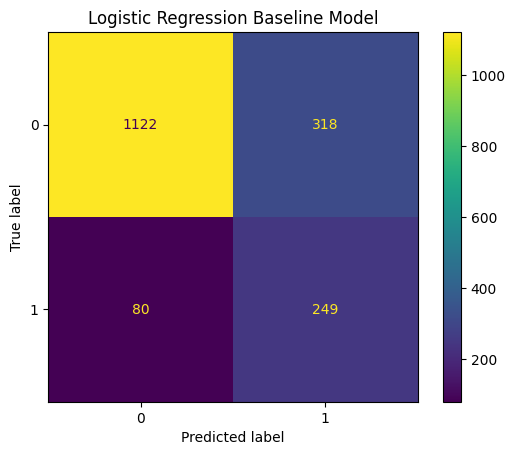

In [61]:
ConfusionMatrixDisplay.from_estimator(basel_mod_reg, X_test_pp, y_test)
plt.title('Logistic Regression Baseline Model');

As we see here even with a 77% accuracy we still have a big amount of False positives and False Negatives, let's try to improve that, let's also look at the ROC Curve plot for our Baseline Model

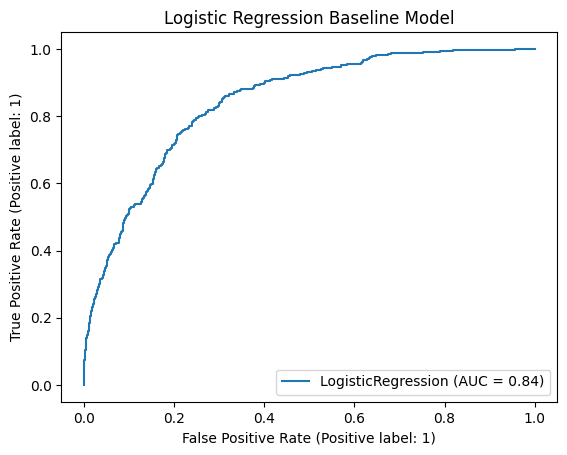

In [62]:
RocCurveDisplay.from_estimator(basel_mod_reg, X_test_pp, y_test)
plt.title("Logistic Regression Baseline Model");

We have an area under the curve of 0.84. We're displaying it for model understanding purposes, but since our focus is accuracy we're not going to focus on optimizing the True Positive Rate.

## Baseline Decision Tree Model

We create a baseline model using a decision tree. Keeping our Random State so we have consistency in the results but just leaving default parameters for everything else.

In [63]:
# Instantiating the decision tree
tree_baseline = DecisionTreeClassifier(random_state=420)
#Fitting and getting scores for both train and test
tree_baseline.fit(X_train_resampled, y_train_resampled)
dt_train_score = tree_baseline.score(X_train_resampled, y_train_resampled)
dt_test_score = tree_baseline.score(X_test_pp, y_test)
y_hat_dt_train = tree_baseline.predict(X_train_resampled)
y_hat_dt_test  = tree_baseline.predict(X_test_pp)

In [64]:
#Printing results
print(F"""
Results for the Decision Tree Baseline Model:

Accuracy train Data: {round(accuracy_score(y_train_resampled,y_hat_dt_train),3)}
Accuracy test Data: {round(accuracy_score(y_test,y_hat_dt_test),3)}

Recall train Data: {round(recall_score(y_train_resampled,y_hat_dt_train),3)}
Recall test Data: {round(recall_score(y_test,y_hat_dt_test),3)}

Precision train Data: {round(precision_score(y_train_resampled,y_hat_dt_train),3)}
Precision test Data: {round(precision_score(y_test,y_hat_dt_test),3)}

F1 train Data: {round(f1_score(y_train_resampled,y_hat_dt_train),3)}
F1 test Data: {round(f1_score(y_test,y_hat_dt_test),3)}
""")


Results for the Decision Tree Baseline Model:

Accuracy train Data: 1.0
Accuracy test Data: 0.775

Recall train Data: 1.0
Recall test Data: 0.45

Precision train Data: 1.0
Precision test Data: 0.405

F1 train Data: 1.0
F1 test Data: 0.427



Let's plot the decision tree, confusion Matrix and the ROC Curve to evaluate it.

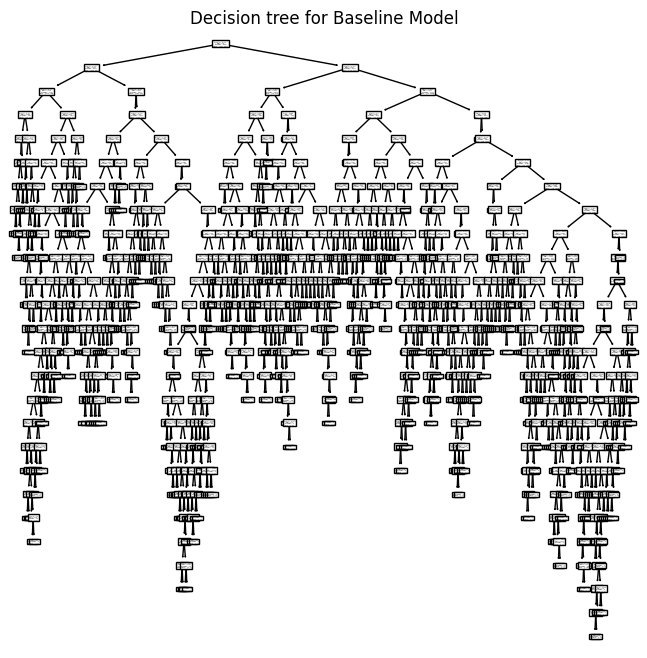

In [65]:
f, ax = plt.subplots(figsize=(8, 8))
plot_tree(tree_baseline, ax=ax)
plt.title('Decision tree for Baseline Model');

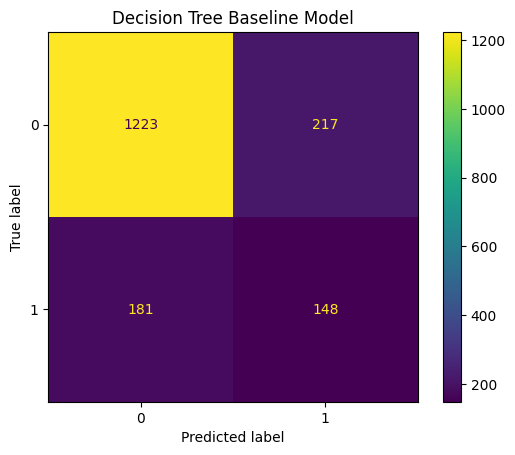

In [66]:
ConfusionMatrixDisplay.from_estimator(tree_baseline.fit(X_train_resampled, y_train_resampled), X_test_pp, y_test)
plt.title('Decision Tree Baseline Model');

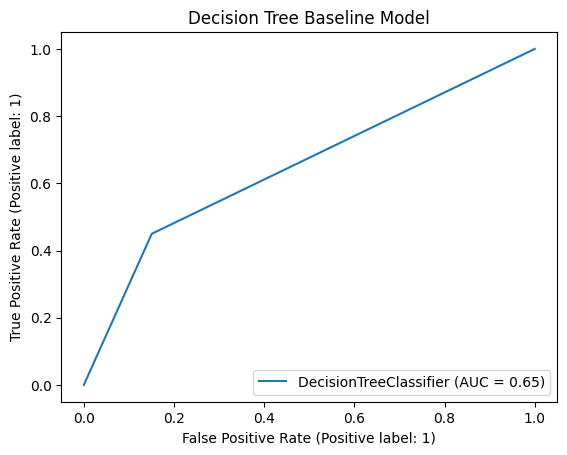

In [67]:
RocCurveDisplay.from_estimator(tree_baseline.fit(X_train_resampled, y_train_resampled), X_test_pp, y_test)
plt.title("Decision Tree Baseline Model");

There we have the plots for the decision tree model. On the first one, we can clearly see that is a model that tends to overfit.

We show an area under the curve of 0.65. That along with the Recall tells us that this is not a good model to try to avoid False positives. Since in our confusion Matrix we have more false positives than true positives.

Let's try to improve our hyperparameters, by creating a class that loops through all the possible combinations and then gives us the best combination of them.

## Building a Model Validator Class

We want to be able to do a complete analysis of the model within our class. Choose the hyperparameters, cross-validate the model, plot the necessary graphs to evaluate it, and get the most important features and the score for each metric.

In [68]:
#Defining the class

class ModelValidator():
    # Creating attributes that define and use later
    
    def __init__(self,X_train,y_train,X_test,y_test):
        self.X_train = X_train
        self.y_train = y_train
        self.X_test = X_test
        self.y_test = y_test      
        self.cv_results = None
        self.cv_mean = None
        self.cv_top_lr = None
        self.cv_top_dt = None
        self.top_hp_lr = None
        self.top_3_lr = None
        self.top_hp_dt = None
        self.top_3_dt = None
        self.top_model_lr = None
        self.top_model_dt = None

     
    # Defining the cross-validation method
        
    def cross_validate(self, model, kfolds=10):
        self.cv_results = cross_val_score(model, self.X_train, self.y_train, cv=kfolds)
        self.cv_mean = np.mean(self.cv_results)
        return self.cv_mean

   #Defining my logistic regression improving method.
    
    def check_log_reg(self, cv_now=False):
        #Create a dictionary with ranges on the hyperparameters
        log_reg_hyperp = {
            'C': [0.01,0.1, 1.0,10,100,1000,10000],
            'penalty': ['l1', 'l2','elasticnet'],
            'solver': ['lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky','sag'],
            'tol': [1e-5,1e-4, 1e-3],
            'random_state': [420],
            'max_iter':[100000]
    }
        
        top_3_lr = []

        #Instantiating the model and looping through the different combinations of hyperparameters for a logistic regression model.
        
        model_inst = LogisticRegression()
        for params in ParameterGrid(log_reg_hyperp):
            try:
                model_inst.set_params(**params)
                model_inst.fit(self.X_train, self.y_train)
                y_pred = model_inst.predict(self.X_test)
                test_accuracy = accuracy_score(self.y_test, y_pred)
                if cv_now:
                    cv_accuracy = self.cross_validate(model_inst)
                    top_3_lr.append((params, cv_accuracy, test_accuracy))
                else:
                    top_3_lr.append((params, test_accuracy))
                
            except ValueError as e:
                continue

        top_3_lr.sort(key=lambda x: x[-1], reverse=True)
        top_hp_lr = top_3_lr[:1]
        top_3_lr = top_3_lr[:3]
        
        # Saving the attributes
        
        self.top_3_lr = top_3_lr
        self.top_hp_lr = top_hp_lr
        self.top_model_lr = LogisticRegression().set_params(**self.top_hp_lr[0][0]).fit(self.X_train,self.y_train)


    # Defining a model method to loop and find the best combination of hyperparameters for my decision tree
    
    def check_desc_tree(self, cv_now=False):
        
        #Creating a dictionary with the hyperparameters combinations
        
        decision_tree_hyperp = {
        'criterion': ['gini','entropy','log_loss'],
        'max_depth': range(1,5),
        'min_samples_split': range(2,4),
        'min_samples_leaf': range(1,4),
        'random_state':[420]
        }
        
        top_3_dt = []

        #Instantiating the model, looping through them and finding top performers
        
        model_inst = DecisionTreeClassifier()
        for params in ParameterGrid(decision_tree_hyperp):
            try:
                model_inst.set_params(**params)
                model_inst.fit(self.X_train, self.y_train)
                y_pred = model_inst.predict(self.X_test)
                test_accuracy = accuracy_score(self.y_test, y_pred)
                if cv_now:
                    cv_accuracy = self.cross_validate(model_inst)
                    top_3_dt.append((params, cv_accuracy, test_accuracy))
                else:
                    top_3_dt.append((params, accuracy))
            except ValueError as e:
                continue

        top_3_dt.sort(key=lambda x: x[-1], reverse=True)
        top_hp_dt = top_3_dt[:1]
        top_3_dt = top_3_dt[:3]

        #Saving attributes
        
        self.top_3_dt = top_3_dt
        self.top_hp_dt = top_hp_dt
        self.top_model_dt = DecisionTreeClassifier().set_params(**self.top_hp_dt[0][0]).fit(self.X_train,self.y_train)

        # Plotting Confusion Matrix for top performing models
    
    def plot_confusion_matrix(self):
        if self.top_hp_lr[0][-1] > self.top_hp_dt[0][-1]:
            top_model = LogisticRegression().set_params(**self.top_hp_lr[0][0]).fit(self.X_train,self.y_train)
            model_type = 'Logistic Regression'
        else:
            top_model = DecisionTreeClassifier().set_params(**self.top_hp_dt[0][0]).fit(self.X_train,self.y_train)
            model_type = 'Decision Tree'
        ConfusionMatrixDisplay.from_estimator(top_model, self.X_test, self.y_test)
        plt.title(f"Confusion Matrix for {model_type}");
        
        #Plotting ROC Curve for top performing models
    
    def plot_roc_curve(self):
        if self.top_hp_lr[0][-1] > self.top_hp_dt[0][-1]:
            top_model = LogisticRegression().set_params(**self.top_hp_lr[0][0]).fit(self.X_train,self.y_train)
            model_type = 'Logistic Regression'
        else:
            top_model = DecisionTreeClassifier().set_params(**self.top_hp_dt[0][0]).fit(self.X_train,self.y_train)
            model_type = 'Decision Tree'
        RocCurveDisplay.from_estimator(top_model, self.X_test, self.y_test)
        plt.title(F"ROC Curve for {model_type}");

        #Determining most important features for my data
    
    def feature_importance(self, n=10):
        if self.top_hp_lr[0][-1] < self.top_hp_dt[0][-1]:
            top_model = DecisionTreeClassifier().set_params(**self.top_hp_dt[0][0])
            features_used = self.X_train.columns
            top_model.fit(self.X_train, self.y_train)
            feature_importance = list(zip(top_model.feature_importances_, features_used))
        else:
            top_model = LogisticRegression().set_params(**self.top_hp_lr[0][0])
            top_model.fit(self.X_train, self.y_train)
            features_used = self.X_train.columns
            feature_importance = list(zip(abs(top_model.coef_[0]), features_used))
            
        feature_importance.sort(key=lambda x: x[0], reverse=True)
        return feature_importance[:n]


        #Creating a method to obtain the score DataFrame
    def scores(self, both_models=False):
        dt_y_hat_train = self.top_model_dt.predict(self.X_train)
        dt_y_hat_test = self.top_model_dt.predict(self.X_test)
        lr_y_hat_train = self.top_model_lr.predict(self.X_train)
        lr_y_hat_test = self.top_model_lr.predict(self.X_test)
        self.cv_top_lr = self.top_hp_lr[0][1]
        self.cv_top_dt = self.top_hp_dt[0][1]
        
        dt_df = {
            'Accuracy train':round(accuracy_score(self.y_train,dt_y_hat_train),3),
            'Accuracy test':round(accuracy_score(self.y_test,dt_y_hat_test),3),
            'Recall train':round(recall_score(self.y_train,dt_y_hat_train),3),
            'Recall test':round(recall_score(self.y_test,dt_y_hat_test),3),
            'Precision train':round(precision_score(self.y_train,dt_y_hat_train),3),
            'Precision test':round(precision_score(self.y_test,dt_y_hat_test),3),
            'F1 train':round(f1_score(self.y_train,dt_y_hat_train),3),
            'F1 test':round(f1_score(self.y_test,dt_y_hat_test),3),
            'CV results': round(self.cv_top_dt,3)
        }

        lr_df = {
            'Accuracy train':round(accuracy_score(self.y_train,lr_y_hat_train),3),
            'Accuracy test':round(accuracy_score(self.y_test,lr_y_hat_test),3),
            'Recall train':round(recall_score(self.y_train,lr_y_hat_train),3),
            'Recall test':round(recall_score(self.y_test,lr_y_hat_test),3),
            'Precision train':round(precision_score(self.y_train,lr_y_hat_train),3),
            'Precision test':round(precision_score(self.y_test,lr_y_hat_test),3),
            'F1 train':round(f1_score(self.y_train,lr_y_hat_train),3),
            'F1 test':round(f1_score(self.y_test,lr_y_hat_test),3),
            'CV results': round(self.cv_top_lr,3)
        }

        decision_tree_df = pd.DataFrame(list(dt_df.values()), index=dt_df.keys(), columns=['Decision Tree'])
        logistic_regression_df = pd.DataFrame(list(lr_df.values()), index=lr_df.keys(), columns=['Logistic Regression'])

        if both_models:
            df = pd.concat([decision_tree_df,logistic_regression_df],axis=1)
            return df
        else:
            if self.top_hp_lr[0][-1] < self.top_hp_dt[0][-1]:
                return decision_tree_df
            else:
                return logistic_regression_df
                
    #Creating a method to plot the decision tree
    
    def plot_tree(self):
        f, ax = plt.subplots(figsize=(8, 8))
        plot_tree(self.top_model_dt, ax=ax)
        plt.title('Decision Tree Classifier');

## Observing the best performing Model

With our class, we are going to evaluate our dataset and then establish the hyperparameters that give us the best accuracy.

Afterwards we'll explore our results and compare with our baseline models shown above.

In [69]:
#Instantiating our ModelValidator class
validator = ModelValidator(X_train_resampled, y_train_resampled,X_test_pp,y_test)

#Calling the decision tree and logistic regression checking functions including the cross validation.

validator.check_desc_tree(cv_now=True)
validator.check_log_reg(cv_now=True)

In [70]:
# Observing the best hyperparameters for logistic regression

validator.top_hp_lr

[({'C': 1.0,
   'max_iter': 100000,
   'penalty': 'l1',
   'random_state': 420,
   'solver': 'liblinear',
   'tol': 0.0001},
  0.7995991125786812,
  0.776144714527982)]

In [71]:
#Observing the best hyperparameters for decision trees

validator.top_hp_dt

[({'criterion': 'gini',
   'max_depth': 4,
   'min_samples_leaf': 1,
   'min_samples_split': 2,
   'random_state': 420},
  0.8264313538334539,
  0.7964951950254381)]

As we can see above the decision tree model had better accuracy, but let's take a better look by comparing the best-performing set of hyperparameters for both models 

In [72]:
#Looking at different scores,
validator.scores(both_models=True)

,Decision Tree,Logistic Regression
Accuracy train,0.829,0.808
Accuracy test,0.796,0.776
Recall train,0.809,0.831
Recall test,0.638,0.760
Precision train,0.842,0.794
Precision test,0.466,0.441
F1 train,0.825,0.812
F1 test,0.538,0.558
CV results,0.826,0.800


Compared to the baseline decision tree, we have a much simpler version that won't lead us that much to overfitting.

## Feature Importance

Now, let's take a look at what are the most important features and its weight on our decision model

In [73]:
# Looking at the Feature importance:
validator.feature_importance(10)

[(0.5386604128264771, 'like'),
 (0.2376586873522825, 'funny_o'),
 (0.06487794394032843, 'd_shared_interests_o'),
 (0.06038099058060674, 'd_like'),
 (0.0600448551523998, 'd_attractive_o'),
 (0.016088921278930305, 'attractive_o'),
 (0.00805904079162653, 'met'),
 (0.007569471778465005, 'd_funny_partner'),
 (0.004367621947046811, 'attractive_important'),
 (0.0022920543518366934, 'field_Psychology')]

## Trying to further improve

We can see that those are the most improtant features, so in order to try to make it simpler let's run a model that has only those columns

In [74]:
important_columns = []
for i in validator.feature_importance(10):
    important_columns.append(i[1])
important_columns

X_train_s = X_train_resampled[important_columns].copy()
X_test_s = X_test_pp[important_columns].copy()

#Instantiating our ModelValidator class on the simplified dataset
validator_simple = ModelValidator(X_train_s, y_train_resampled,X_test_s,y_test)

#Calling the decision tree and logistic regression checking functions including the cross-validation for our new object

validator_simple.check_desc_tree(cv_now=True)
validator_simple.check_log_reg(cv_now=True)

validator_simple.scores(both_models=True)

,Decision Tree,Logistic Regression
Accuracy train,0.829,0.766
Accuracy test,0.796,0.733
Recall train,0.809,0.793
Recall test,0.638,0.787
Precision train,0.842,0.753
Precision test,0.466,0.392
F1 train,0.825,0.772
F1 test,0.538,0.523
CV results,0.827,0.766


Here we noticed the same scores than on our first model, but having less features makes it simple and faster.

## Polynomial features

Now that we have less columns, let's try to add som complexity to see if we can improve our accuracy.

In [75]:
poly = PolynomialFeatures(interaction_only=False, include_bias=False)
poly.fit(X_train_s)
new_col_names = pd.Series(poly.get_feature_names_out(X_train_s.columns)).str.replace(" ", " x ")
X_train_int = pd.DataFrame(poly.transform(X_train_s), columns=new_col_names)
X_test_int = pd.DataFrame(poly.transform(X_test_s), columns=new_col_names)

validator_pol_int = ModelValidator(X_train_int, y_train_resampled,X_test_int,y_test)
validator_pol_int.check_desc_tree(cv_now=True)
validator_pol_int.check_log_reg(cv_now=True)

validator_pol_int.scores(both_models=True)

,Decision Tree,Logistic Regression
Accuracy train,0.796,0.807
Accuracy test,0.807,0.757
Recall train,0.738,0.840
Recall test,0.644,0.726
Precision train,0.834,0.788
Precision test,0.486,0.413
F1 train,0.783,0.813
F1 test,0.554,0.527
CV results,0.795,0.801


In [76]:
validator_pol_int.top_hp_lr

[({'C': 100,
   'max_iter': 100000,
   'penalty': 'l1',
   'random_state': 420,
   'solver': 'liblinear',
   'tol': 1e-05},
  0.8006306108760706,
  0.7574901074053138)]

In [77]:
validator_pol_int.top_hp_dt

[({'criterion': 'gini',
   'max_depth': 2,
   'min_samples_leaf': 1,
   'min_samples_split': 2,
   'random_state': 420},
  0.7947274533071921,
  0.8072357263990956)]

In [78]:
validator_pol_int.scores(both_models=True)

,Decision Tree,Logistic Regression
Accuracy train,0.796,0.807
Accuracy test,0.807,0.757
Recall train,0.738,0.840
Recall test,0.644,0.726
Precision train,0.834,0.788
Precision test,0.486,0.413
F1 train,0.783,0.813
F1 test,0.554,0.527
CV results,0.795,0.801


## Results

Here, we can clearly see that the decision tree with just the most important columns and polynomial features performs better in almost every metric, also being the model that will be faster to deploy.

Now let's look at some plots of this model to evaluate its performance.

In [79]:
validator_pol_int.feature_importance(5)

[(0.6002786472407949, 'like'),
 (0.28942722900602147, 'like x attractive_o'),
 (0.1102941237531836, 'd_shared_interests_o^2'),
 (0.0, 'funny_o'),
 (0.0, 'd_shared_interests_o')]

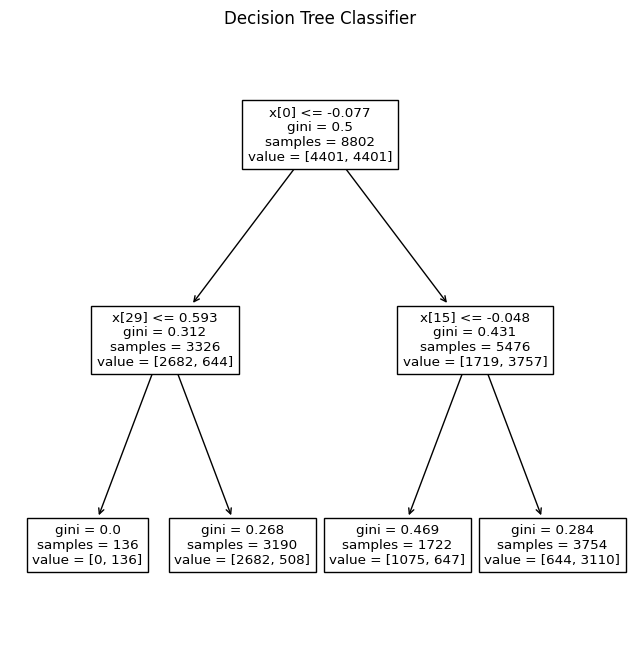

In [80]:
#Plotting decision tree
validator_pol_int.plot_tree()

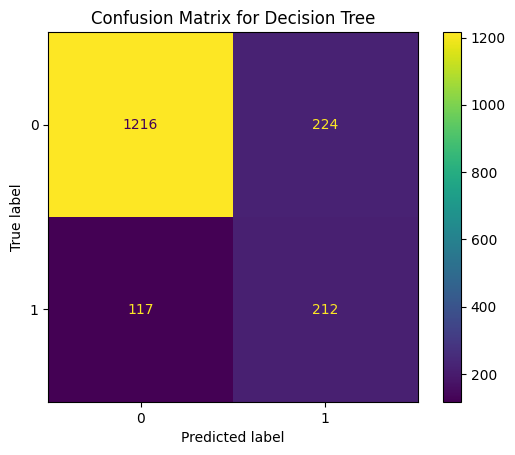

In [81]:
# Plotting confusion matrix
validator_pol_int.plot_confusion_matrix()

Compared to our baseline model, we had an important improve on the true positive rate, even though we have 7 more false positives.

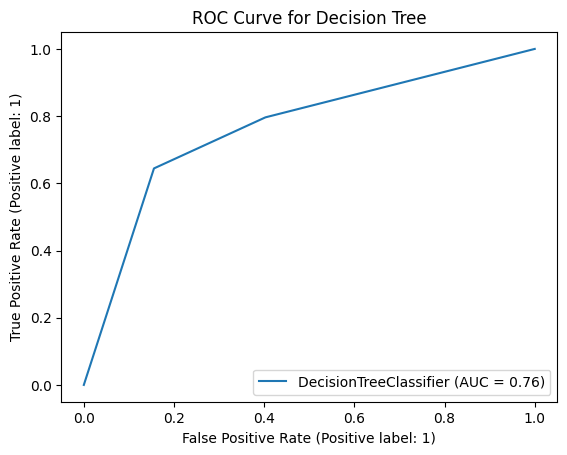

In [82]:
# Plotting ROC Curve
validator_pol_int.plot_roc_curve()

The Area under the curve improved from 0.64 to 0.76, which is consistent with what we saw on the confusion Matrix, an improvement in the True Positive Rate.

As we can see, the most important factor in determining a match is whether or not the couple likes each other, which might seem intuitive. Whether they found each other attractive and the amount of shared interest they had.

# Recommendations

* Create workshops for grooming and style.
* Classes to break the ice to avoid effect of just meeting someone.
* Create premium tier to make people more likely to match.

# Next Steps

* We can create subsets by race or gender so we can further analyze what are the most important factors for each sub-category at the moment of finding a partner.
* We can extract the non-important features and evaluate how our model performs.
* We can also extract from our analysis the features that are more important when matching and creating personalized recommendations